In [ ]:
import os
import cv2 # Görüntülerle işlem yapmamızı sağlayan bir kütüphane imread, imwrite gibi düşünülebilir.
import numpy as np
import albumentations as A
from albumentations.core.bbox_utils import convert_bboxes_to_albumentations, convert_bboxes_from_albumentations

# Albumentations kütüphanesiyle geliştirilmiş veri artırma işlemleri
augmentation_process = A.Compose(
    [
        A.HorizontalFlip(p=0.5),  # Yatay çevirme
        A.VerticalFlip(p=0.5),  # Dikey çevirme (bazı medikal verilerde uygundur)
        A.Rotate(limit=20, border_mode=cv2.BORDER_CONSTANT, p=0.5),  # Döndürme (maksimum 20 derece)
        A.Transpose(p=0.5), #Görüntünün Transpose'u
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),  # Kaydırma, ölçekleme ve hafif döndürme

        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5 ),  # Parlaklık ve kontrast ayarı
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),  # Gamma dönüşümü
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  # Elastik deformasyon
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),  # Çoğul gürültü ekleme
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),  # Histogram eşitleme

        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5), # Keskinleştirme

        A.Emboss(alpha=(0.2, 0.5), strength=(1, 1), p=0.5), # Kabartma
        A.MotionBlur(blur_limit=5, p=0.5), # Hareket Bulanıklılığı
        A.Blur(blur_limit=(9, 11), p=0.5), # Bulanıklılık

        A.ISONoise(color_shift=(0.2, 0.3), intensity=(0.9, 1), p=0.5), # ISO Gürültüsü
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5), # Gaussian Gürültü

        A.RandomCrop(width=320, height=320, p=0), # Rastgele Kırpma

        A.CoarseDropout(num_holes_range=(5, 8), hole_height_range=(10, 15), hole_width_range=(10, 15), fill="random_uniform", p=0.5),
        #Rastgele yerleri keserek görüntüde boşluklar oluşturur

        A.PixelDropout(drop_value=20, p=0.5), #Rastgele pikselleri düşürme

        A.RandomFog(fog_coef_lower=0.9, fog_coef_upper=1, p=0.5), #Sis efekti
        A.RandomRain(slant_lower=-10, slant_upper=10, drop_width=1, p=0.5), # Yağmur Efekti
        A.OpticalDistortion(distort_limit=1, p=0.5), # Optik bozulma


        A.Resize(height=640, width=640, p=1),  # YOLO için sabit boyut ayarlama
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])  # YOLO formatını destekler
)


# Labelları okuyup güncelleyen yardımcı fonksiyon

def augment_and_save_yolo(image_path, label_path, output_image_dir, output_label_dir, num_augmentations=10):
    """
    YOLO formatındaki bir X-ray görüntüsüne veri artırma uygular ve sonuçları kaydeder.

    Args:
        image_path (str): Orijinal görüntü dosya yolu
        label_path (str): Orijinal etiket dosya yolu
        output_image_dir (str): Augmente edilmiş görüntülerin kaydedileceği klasör
        output_label_dir (str): Augmente edilmiş etiketlerin kaydedileceği klasör
        num_augmentations (int): Üretilecek augmente edilmiş+ görüntü sayısı
    """

    # Görüntüyü yükle
    image = cv2.imread(image_path)
    if image is None:
        print(f"Görüntü yüklenemedi: {image_path}")
        return

    # YOLO etiketlerini yükle
    with open(label_path, "r") as f:
        bboxes = []
        class_labels = []
        for line in f:
            elements = line.strip().split()
            class_id = int(elements[0])
            bbox = list(map(float, elements[1:]))
            bboxes.append(bbox)
            class_labels.append(class_id)

    # Çıkış klasörlerini oluştur
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for i in range(num_augmentations):
        # Veri artırma işlemi
        augmented = augmentation_process(image=image, bboxes=bboxes, class_labels=class_labels)
        augmented_image = augmented["image"]
        augmented_bboxes = augmented["bboxes"]
        augmented_class_labels = augmented["class_labels"]

        # Yeni görüntü ve etiket dosya yolları
        file_name = os.path.splitext(os.path.basename(image_path))[0]
        output_image_path = os.path.join(output_image_dir, f"{file_name}_aug_{i}.jpg")
        output_label_path = os.path.join(output_label_dir, f"{file_name}_aug_{i}.txt")

        # Augmente edilmiş görüntüyü kaydet
        cv2.imwrite(output_image_path, augmented_image)

        # Augmente edilmiş etiketleri kaydet
        with open(output_label_path, "w") as f:
            for bbox, class_id in zip(augmented_bboxes, augmented_class_labels):
                f.write(f"{class_id} {' '.join(map(str, bbox))}\n")

        print(f"Görüntü ve etiket kaydedildi: {output_image_path}, {output_label_path}")

# Dosya konumları
input_image_dir = '/content/dataset/images' # orijinal görüntülerin kaydedileceği klasör
input_label_dir = '/content/dataset/labels' # orijinal görüntülerin etiketlerinin kaydedileceği klasör
output_image_dir = '/content/aug_data/aug_images' # augmente edilmiş görüntülerin kaydedileceği klasör
output_label_dir = '/content/aug_data/aug_labels' # augmente edilmiş görüntülerin etiketlerinin kaydedileceği klasör

# Görüntü ve etiket dosyalarını eşleştir (jpg)
image_files = [f for f in os.listdir(input_image_dir) if f.endswith(".jpg")]
for image_file in image_files:
    image_path = os.path.join(input_image_dir, image_file)
    label_path = os.path.join(input_label_dir, os.path.splitext(image_file)[0] + ".txt")
    if os.path.exists(label_path):
        augment_and_save_yolo(image_path, label_path, output_image_dir, output_label_dir)

# Görüntü ve etiket dosyalarını eşleştir (png)
image_files = [f for f in os.listdir(input_image_dir) if f.endswith(".png")]
for image_file in image_files:
    image_path = os.path.join(input_image_dir, image_file)
    label_path = os.path.join(input_label_dir, os.path.splitext(image_file)[0] + ".txt")
    if os.path.exists(label_path):
        augment_and_save_yolo(image_path, label_path, output_image_dir, output_label_dir)

<ipython-input-153-3cc3c8af233a>:18: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  # Elastik deformasyon
<ipython-input-153-3cc3c8af233a>:33: UserWarning: Argument 'fill' is not valid and will be ignored.
  A.CoarseDropout(num_holes_range=(5, 8), hole_height_range=(10, 15), hole_width_range=(10, 15), fill="random_uniform", p=0.5),


Görüntü ve etiket kaydedildi: /content/aug_data/kopek_images/köple_aug_0.jpg, /content/aug_data/kopek_labels/köple_aug_0.txt
Görüntü ve etiket kaydedildi: /content/aug_data/kopek_images/köple_aug_1.jpg, /content/aug_data/kopek_labels/köple_aug_1.txt
Görüntü ve etiket kaydedildi: /content/aug_data/kopek_images/köple_aug_2.jpg, /content/aug_data/kopek_labels/köple_aug_2.txt
Görüntü ve etiket kaydedildi: /content/aug_data/kopek_images/köple_aug_3.jpg, /content/aug_data/kopek_labels/köple_aug_3.txt
Görüntü ve etiket kaydedildi: /content/aug_data/kopek_images/köple_aug_4.jpg, /content/aug_data/kopek_labels/köple_aug_4.txt
Görüntü ve etiket kaydedildi: /content/aug_data/kopek_images/köple_aug_5.jpg, /content/aug_data/kopek_labels/köple_aug_5.txt
Görüntü ve etiket kaydedildi: /content/aug_data/kopek_images/köple_aug_6.jpg, /content/aug_data/kopek_labels/köple_aug_6.txt
Görüntü ve etiket kaydedildi: /content/aug_data/kopek_images/köple_aug_7.jpg, /content/aug_data/kopek_labels/köple_aug_7.txt


# **OLUŞTURULAN AUGMENTE EDİLMİŞ GÖRÜNTÜLER ARASINDAN RASTGELE SEÇİM YAPIP BOUNDING BOX ILE BERABER ÇİZDİRME**

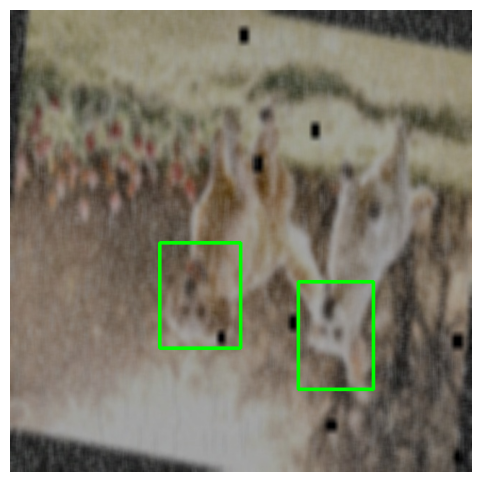

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Klasör yolları
train_images = '/content/aug_data/aug_images'
train_labels = '/content/aug_data/aug_labels'

# Tüm görüntüleri al
image_files = os.listdir(train_images)

# Rastgele bir görüntü seç
random_image = random.choice(image_files)

# Görüntü ve etiket yolları
image_path = os.path.join(train_images, random_image)
label_file = os.path.splitext(random_image)[0] + ".txt"
label_path = os.path.join(train_labels, label_file)

# Görüntüyü yükle
image = cv2.imread(image_path)

# Eğer görüntü yüklenemediyse hata mesajı göster
if image is None:
    print(f"Hata: {image_path} yüklenemedi.")
else:
    # Etiketleri yükle
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Bbox'ları çiz
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width / 2) * image.shape[1])
        y_min = int((y_center - height / 2) * image.shape[0])
        x_max = int((x_center + width / 2) * image.shape[1])
        y_max = int((y_center + height / 2) * image.shape[0])

        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    # Görüntüyü göster
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    plt.show()
